Name: Holly Kular\
Date: 03-19-2024\
Email: hkular@ucsd.edu\
decode_L1.m\
Description: Script for decoding analysis on layer 1 of probabilistic RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.optimize import curve_fit
from scipy.io import loadmat
from fnc_fit_and_score import fnc_fit_and_score
from multiprocessing import Pool

In [177]:
# MODIFY HERE
# what conditions were the RNNs trained on?
RNN_params = {
    'prob_split': '70_30',
    'afc': 6,
    'coh': 'hi',
    'feedback': False,
    'thresh': [.3, .7],
    'model': 1
}

D_params = {
    'time_avg': False,
    't_win': [130, -1],
    'n_cvs': 5,
    'num_cgs': 30,
    'label': 'stim',  # 'stim' or 'choice'
    'units': 'all',  # 'all' or 'exc' or 'inh'
    'pred': 'all'  # 'expected' or 'unexpected', 'all'
}

# Timing of task
task_info = {
    'trials': 1000,
    'trial_dur': 250,
    'stim_on': 80,
    'stim_dur': 50
}

n_cvs = 5
window = 50
# store the accuracy
acc = np.full( ( n_cvs ), np.nan )

# penalties to eval
num_cgs = 30
Cs = np.logspace( -5,1,num_cgs )

# set up the grid
param_grid = { 'C': Cs, 'kernel': ['linear'] }

# define object - use a SVC that balances class weights (because they are biased, e.g. 70/30)
# note that can also specify cv folds here, but I'm doing it by hand below in a loop
grid = GridSearchCV( SVC(class_weight = 'balanced'),param_grid,refit=True,verbose=0 )

# Data Directory
# Load data
if sys.platform.startswith('linux'):
    data_dir = f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/rdk_{RNN_params['prob_split']}_{RNN_params['afc']}afc/feedforward_only/{RNN_params['coh']}_coh"
else:
    data_dir = f"/Volumes/serenceslab/holly/RNN_Geo/data/rdk_{RNN_params['prob_split']}_{RNN_params['afc']}afc/feedforward_only/{RNN_params['coh']}_coh"

# Chose the model
mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat')]# Get all the trained models (should be 40 .mat files)
model_path = os.path.join(data_dir, mat_files[1]) 
model = loadmat(model_path) # model.keys()

In [178]:
# Decode trials: RNN stim presented

# get the data from layer 1 decode stim
# this is a [trial x time step x unit] matrix
data_file = f"{data_dir}/Trials{task_info['trials']}_model{model_path[-7:-4]}_balanced.npz"
data = np.load(data_file)
data_d = data['fr1']
if D_params['label'] == 'stim':
    labs = data['labs'].squeeze()
elif D_params['label'] == 'choice':
    labs = data['outs'][:,-1]

# get some info about structure of the data
tris = data_d.shape[0]             # number of trials
tri_ind = np.arange(0,tris)      # list from 0...tris
hold_out = int( tris / n_cvs )   # how many trials to hold out


In [4]:
def sliding_window(elements, window_size):
  if len(elements) <= window_size:
    return elements

  windows = []
  for i in range(len(elements) - window_size + 1):
    windows.append(elements[i:i + window_size])

  return windows

In [35]:
def update_progress(progress, total):
    bar_length = 20  # Adjust this for desired bar length
    filled_length = int(round(progress / total * bar_length))
    bar = '=' * filled_length + '-' * (bar_length - filled_length)
    print(f'Progress: [{bar}] {progress}/{total}', end='\r')

In [ ]:
# Do decoding - no parallel 
decoding_acc = np.zeros((len(range(task_info['stim_dur']+task_info['stim_on'],task_info['trial_dur'])),))

times = sliding_window(range(task_info['stim_dur']+task_info['stim_on'],task_info['trial_dur']), window)
counter = 0
for t in times:

  # Get data slice for the current window avg
    data_slice = np.mean( data_d[:,t, :], axis = 1 )    # loop over cvs and do classification
    for i in range(n_cvs):

        # trials to hold out as test set on this cv fold
        tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

        # index into the training data on this cv fold
        trn_ind = np.setdiff1d( tri_ind, tst_ind )

        # get the training data (X) and the training labels (y)
        X = data_slice[ trn_ind,: ]
        if label == 'stim':
            y = labs[trn_ind]
        else:
            y = np.select([labs[trn_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [0,1], default=0)


        # Fit the model on the binary labels
        grid.fit( X, y )

        # get the test data (X) and the test labels (y)
        X_test = data_slice[tst_ind, :]
        if label == 'stim':
            y_test = labs[tst_ind]
        else:
            y_test = np.select([labs[tst_ind] >= thresh[1], labs[tst_ind] <= thresh[0]], [0,1], default=0)


        # predict!
        y_pred = grid.predict(X_test)
        score = grid.score( X_test,y_test )
        acc[i] += score  # Append accuracy for this CV fold

        # Evaluate accuracy
        accuracy = np.mean( acc )

            
    counter +=1
    decoding_acc[counter] = np.mean(acc)

        
print(f'done decoding')

In [179]:
label = D_params.get('label', 'stim')
thresh = RNN_params.get('thresh', [.3, .7])
if label == 'stim':
    n_classes = len(np.unique(labs))
else:
    n_classes = 2
if D_params['time_avg'] :
    data_d = np.mean( data_d[ :,D_params['t_win'][0]:D_params['t_win'][1],: ], axis = 1 ) # average over time window
    acc = np.zeros(n_cvs)
    cm = np.zeros((n_cvs, n_classes, n_classes))
    class_acc = np.zeros((n_cvs, n_classes))
    # Within each cross-validation fold
    for i in range(n_cvs):

        # trials to hold out as test set on this cv fold
        tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

        # index into the training data on this cv fold
        trn_ind = np.setdiff1d( tri_ind, tst_ind )

        # get the training data (X) and the training labels (y)
        X = data_d[ trn_ind,: ]
        if label == 'stim':
            y = labs[trn_ind]
        else:
            y = np.select([labs[trn_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [0,1], default=0)


        # Fit the model on the binary labels
        grid.fit( X, y )

        # get the test data (X) and the test labels (y)
        X_test = data_d[tst_ind, :]
        if label == 'stim':
            y_test = labs[tst_ind]
        else:
            y_test = np.select([labs[tst_ind] >= thresh[1], labs[tst_ind] <= thresh[0]], [0,1], default=0)


        # predict!
        y_pred = grid.predict(X_test)
        score = grid.score( X_test,y_test )
        acc[i] += score  # Append accuracy for this CV fold
        # confusion matrix
        cm[i] += confusion_matrix(y_test, y_pred)

        # Evaluate accuracy
        accuracy = np.mean( acc )
        for cls in range(n_classes):
            cls_ind = y_test == cls
            class_acc[i, cls] += (np.sum(y_pred[cls_ind] == cls) / np.sum(cls_ind))
            
        
        # Print overall results
        #print(f'CV: {i}, {grid.best_estimator_}')  
    cm_mean = np.mean(cm, axis = 0)
else:
# Do decoding - parallel 
    times = sliding_window(range(task_info['stim_dur']+task_info['stim_on'],task_info['trial_dur']), window)
    pool = Pool(processes=round(os.cpu_count() * .8))
    with pool:  # use 70% of cpus
        results = pool.starmap(fnc_fit_and_score, [
            (t, np.mean( data_d[:,t, :], axis = 1 ), tri_ind, hold_out, n_cvs, n_classes, labs, label, thresh, grid)
            for t in times
        ], chunksize = 10)
    pool.close()
    # Process the results from each worker process (list of lists of accuracies)
    #decoding_acc = np.mean(np.array(results), axis=1)
print(f'done decoding')

done decoding


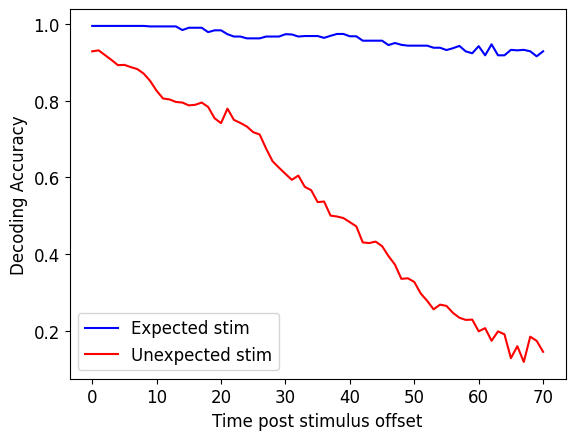

In [180]:
acc = np.array(results)

plt.figure()
plt.plot(acc[:,0], color = 'blue', label = 'Expected stim')
plt.plot(np.mean(acc[:,1:2], axis = 1), color = 'red', label = 'Unexpected stim')
#plt.plot(accs['hi_6_stim_all0'][:,0], color = 'blue', label = 'Expected stim')
#plt.plot(np.mean(accs['hi_6_stim_all0'][:,1:5], axis = 1), color = 'red', label = 'Unexpected stim')
plt.xlabel('Time post stimulus offset') 
plt.ylabel('Decoding Accuracy')
#plt.title('6-AFC high coherence layer 1')
plt.legend()
#plt.savefig(f"{data_dir}/decode_in_exp.png")
plt.show()  

In [175]:
# save output
hi_6_stim_all1 = acc

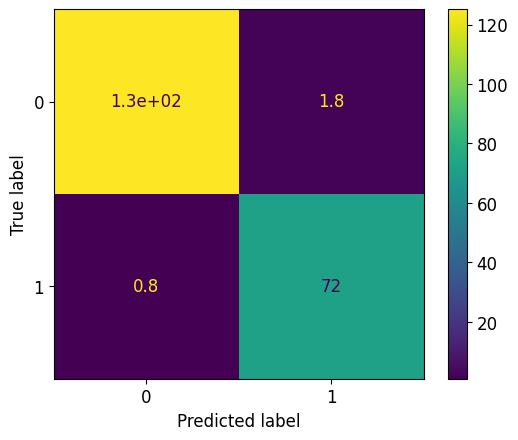

In [82]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm_mean)
disp.plot()
plt.show()

In [ ]:
# Plot decoding accuracy over time
plt.figure()
plt.plot(decoding_acc)
plt.xlabel('Time')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy Over Time')
#plt.savefig(f"{data_dir}/decode_stim_exp.png")
plt.legend()
plt.show()  

In [179]:
# start storing all decoding accuracy results

#------------- hi coh 6afc opts ignoring inh vs exc for now
#results_all['hi']['6afc']['choice']['expected']['all units'] hi_6afc_choice_all 
#results_all['hi']['6afc']['stim']['expected']['all units'] hi_6afc_stim_all 

#-------------- hi coh 2afc opts ignoring inh vs exc for now
#results_all['hi']['2afc']['choice']['expected']['all units'] 
#results_all['hi']['2afc']['stim']['expected']['all units'] hi_2afc_stim_all 



#------------- lo coh 6afc opts ignoring inh vs exc for now
# results_all['lo']['6afc']['choice']['expected']['all units']
#results_all['lo']['6afc']['stim']['expected']['all units'] lo_6afc_stim_all 


#-------------- lo coh 2afc opts ignoring inh vs exc for now
#results_all['lo']['2afc']['choice']['expected']['all units']
#results_all['lo']['2afc']['stim']['expected']['all units'] lo_2afc_stim_all 

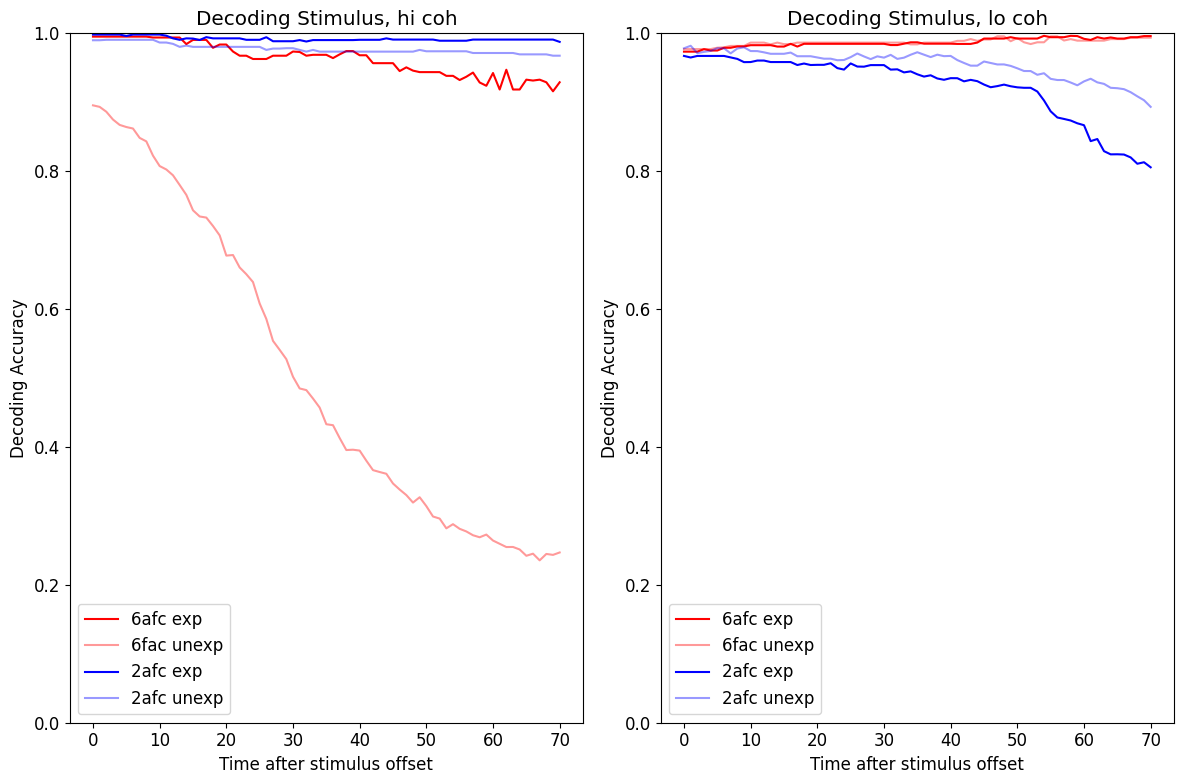

In [148]:
# plots
fig, axs = plt.subplots(1,2, figsize=(12, 8))

# Plot 1
axs[0].plot(accs['hi_6_stim_all1'][:,0], color='red', label='6afc exp')
axs[0].plot(np.mean(accs['hi_6_stim_all1'][:,1:5], axis = 1), color='red', alpha=0.4, label='6fac unexp')
axs[0].plot(accs['hi_2_stim_all1'][:,0], color='blue', label='2afc exp')
axs[0].plot(np.mean(accs['hi_2_stim_all1'][:,1:2], axis = 1), color='blue', alpha=0.4, label='2afc unexp')
axs[0].set_xlabel('Time after stimulus offset')
axs[0].set_ylabel('Decoding Accuracy')
axs[0].set_title('Decoding Stimulus, hi coh')
axs[0].set_ylim(0, 1)
axs[0].legend()

# Plot 2
axs[1].plot(accs['lo_6_stim_all1'][:,0], color='red', label='6afc exp')
axs[1].plot(np.mean(accs['lo_6_stim_all1'][:,1:5], axis = 1), color='red', alpha=0.4, label='6fac unexp')
axs[1].plot(accs['lo_2_stim_all1'][:,0], color='blue', label='2afc exp')
axs[1].plot(np.mean(accs['lo_2_stim_all1'][:,1:2], axis = 1), color='blue', alpha=0.4, label='2afc unexp')
axs[1].set_xlabel('Time after stimulus offset')
axs[1].set_ylabel('Decoding Accuracy')
axs[1].set_title('Decoding Stimulus, lo coh')
axs[1].set_ylim(0, 1)
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.rcParams.update({'font.size': 12})

plt.savefig(f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/decoding/stim_all1_plots_06032024.png")

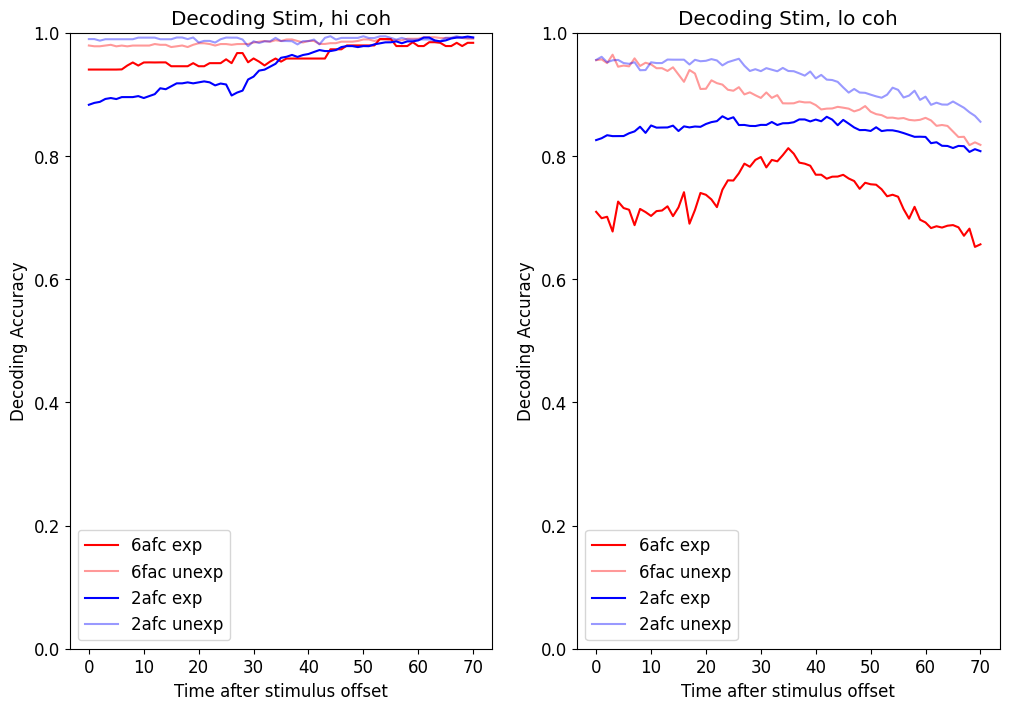

In [149]:
# plots
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

# Plot 1
axs[0].plot(hi_6_choice_all0[:,0], color='red', label='6afc exp')
axs[0].plot(np.mean(hi_6_choice_all0[:,1:2], axis = 1), color='red', alpha=0.4, label='6fac unexp')
axs[0].plot(hi_2_choice_all0[:,0], color='blue', label='2afc exp')
axs[0].plot(np.mean(hi_2_choice_all0[:,1:2], axis = 1), color='blue', alpha=0.4, label='2afc unexp')
axs[0].set_xlabel('Time after stimulus offset')
axs[0].set_ylabel('Decoding Accuracy')
axs[0].set_title('Decoding Choice, hi coh')
axs[0].set_ylim(0, 1)
axs[0].legend()

# Plot 2
axs[1].plot(lo_6_choice_all0[:,0], color='red', label='6afc exp')
axs[1].plot(np.mean(lo_6_choice_all0[:,1:2], axis = 1), color='red', alpha=0.4, label='6fac unexp')
axs[1].plot(lo_2_choice_all0[:,0], color='blue', label='2afc exp')
axs[1].plot(np.mean(lo_2_choice_all0[:,1:2], axis = 1), color='blue', alpha=0.4, label='2afc unexp')
axs[1].set_xlabel('Time after stimulus offset')
axs[1].set_ylabel('Decoding Accuracy')
axs[1].set_title('Decoding Choice, lo coh')
axs[1].set_ylim(0, 1)
axs[1].legend()
#plt.savefig(f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/decoding/choice_all_plots_06032024.png")

In [145]:
full_file = '/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/decoding/results_stim_balanced_all1.npz'
np.savez(full_file, lo_2_stim_all1 = lo_2_stim_all1, lo_6_stim_all1 = lo_6_stim_all1, hi_2_stim_all1 = hi_2_stim_all1, hi_6_stim_all1 = hi_6_stim_all1)

         

In [176]:
full_file = '/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/decoding/results_choice_balanced_all1.npz'
np.savez(full_file, lo_2_choice_all1 = lo_2_choice_all1, lo_6_choice_all1 = lo_6_choice_all1, hi_2_choice_all1 = hi_2_choice_all1, hi_6_choice_all1 = hi_6_choice_all1)


In [29]:
full_file = '/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/decoding/results_balanced_all0.npz'
accs = np.load(full_file)

In [146]:
accs = np.load(full_file)